Last Modification: 2/5/2023

This notebook implements extension with IWAE bound. But the BNNs are not sampled by local reparameterization trick, which is derived and applied in V3 (but it is quite slow and does not help. so for IWAE bound, my implememtation in V2 is enough.)



In [ ]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence, Normal
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms

In [ ]:
class BayesLinear(nn.Module):
    # I do not implement forward for this class to avoid confusion
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight_loc = nn.Parameter(torch.zeros(in_features, out_features))
        self.log_weight_scale = nn.Parameter(torch.zeros(in_features, out_features))
        
        self.bias_loc = nn.Parameter(torch.zeros(out_features))
        self.log_bias_scale = nn.Parameter(torch.zeros(out_features))
        
    def get_params(self):
        """
        return two tensors, obtaining by concatenating locs and scales together
        these parameters can be further used to calculate e.g, KL divergence (vectorizedly)
        """
        return (
                torch.cat([self.weight_loc.flatten(), self.bias_loc.flatten()]), 
                torch.cat([self.log_weight_scale.flatten(), self.log_bias_scale.flatten()])
               )
    
    def forward_with_sample(self, x, x_is_sample, activition_fn, weight_samples, bias_samples):
        """
        forward with samples of parameters.
        args:
            x: tensor or list of tensors
            x_is_sample: bool, indicating that x is tensor or list of tensors(e.g.,  samples generated by previous layers)
            activition_fn: instance of an activition function (.eg., nn.ReLU(), nn.Softmax(), etc.)
            weight_samples, bias_samples: list of samples of parameters
        """
        ys = []
        if x_is_sample:
            for i in range(len(x)):
                weight_sample, bias_sample = weight_samples[i], bias_samples[i]
                y = x[i] @ weight_sample + bias_sample
                ys.append(activition_fn(y))
        else:
            for i in range(len(weight_samples)):
                weight_sample, bias_sample = weight_samples[i], bias_samples[i]
                y = x @ weight_sample + bias_sample
                ys.append(activition_fn(y))
        return ys
    
    def sample_params(self):
        """
        Get samples by reparameterization trick
        """
        weight_sample = torch.exp(self.log_weight_scale) * torch.randn_like(self.weight_loc) + self.weight_loc
        bias_sample = torch.exp(self.log_bias_scale) * torch.randn_like(self.bias_loc) + self.bias_loc
        return [weight_sample, bias_sample]
        
        
    def forward_without_sample(self, x, x_is_sample, activition_fn, n_particles):
        ys = []
        if x_is_sample:
            assert n_particles == len(x)
            for _x in x:
                weight_sample, bias_sample = self.sample_params()
                y = _x @ weight_sample + bias_sample
                ys.append(activition_fn(y))
        else:
            for _ in range(n_particles):
                weight_sample, bias_sample = self.sample_params()
                y = x @ weight_sample + bias_sample
                ys.append(activition_fn(y))
        return ys
    def forward_MLE(self, x, activition_fn):
        y = x @ self.weight_loc + self.bias_loc
        return activition_fn(y)


In [ ]:
# Implement Gonzalez Algorithm for k-Center Clustering for Coreset selection

class KCenter:
    def __init__(self, K):
        self.K = K
    def fit_transform(self, x):
        # fit and return centers
        idx1 = np.random.choice(x.shape[0], 1)
        center = x[idx1] # (1, d)
        idx = [idx1.item()]
        min_distances_to_centers = np.full([1, x.shape[0]], np.inf)
        for k in tqdm(range(1, self.K)):
            distances = ((x[None, :, :] - center[:, None, :]) ** 2).sum(-1) # 1, N
            min_distances_to_centers = np.vstack([min_distances_to_centers, distances]).min(0)
            new_center_idx = np.argmax(min_distances_to_centers).item()
            idx.append(new_center_idx)
            center = x[[new_center_idx]]
        assert len(idx) == self.K
        return idx

In [ ]:
class VCL_permute_MNIST(nn.Module):
    def __init__(self, previous_model, random_initialize):
        super().__init__()
        
        # "fully connected single-head networks with two hidden layers, where each layer contains 100 hidden units with ReLU activation"
        self.linear1 = BayesLinear(28*28, 100)
        self.linear2 = BayesLinear(100, 100)
        self.head = BayesLinear(100, 10)
        
        # intialize distributions as prior distributions
        # I believe there exist better ways to do this, but I am too lazy to think..(sorry)
        
        # define a layer dict
        self.layer_dict = OrderedDict()
        self.layer_dict["linear1"] = self.linear1
        self.layer_dict["linear2"] = self.linear2
        self.layer_dict["head"] = self.head
        
        # just a sanity check 
        assert id(self.layer_dict["linear1"]) == id(self.linear1)
        
        
        with torch.no_grad():
            if previous_model != None:
                for key in self.layer_dict:
                    self.layer_dict[key].weight_loc.data = previous_model.layer_dict[key].weight_loc.data.clone()
                    self.layer_dict[key].bias_loc.data = previous_model.layer_dict[key].bias_loc.data.clone()
                    self.layer_dict[key].log_weight_scale.data  = previous_model.layer_dict[key].log_weight_scale.data.clone()
                    self.layer_dict[key].log_bias_scale.data  = previous_model.layer_dict[key].log_bias_scale.data.clone()
            if random_initialize: 
                # model's initialization
                # random mean and very small variances (do not need to break the symmetricity since the training is based on random samples)
                for key in self.layer_dict:
                    self.layer_dict[key].weight_loc.data = torch.randn_like(self.layer_dict[key].weight_loc.data) * 0.1
                    self.layer_dict[key].bias_loc.data = torch.randn_like(self.layer_dict[key].bias_loc.data) * 0.1
                    # initialize to very small value for the first model
                    self.layer_dict[key].log_weight_scale.data  = torch.zeros_like(self.layer_dict[key].log_weight_scale.data) - 3
                    self.layer_dict[key].log_bias_scale.data  = torch.zeros_like(self.layer_dict[key].log_bias_scale.data) - 3
        
        # also save parameters of the previous model, for the calculation of ELBO
        if  previous_model != None:
            previous_locs, previous_logscales = previous_model.get_params()
            previous_locs, previous_logscales = previous_locs.detach().clone(), previous_logscales.detach().clone()
            self.previous_model_locs = previous_locs
            self.previous_model_log_scales = previous_logscales
        else:
            self.previous_model_locs = None
            self.previous_model_log_scales = None
        
    def predict(self, x, n_particles, param_samples=None):
        if param_samples == None:
            # if the parameters are not sampled
            hiddens =  self.linear1.forward_without_sample(x, x_is_sample=False, activition_fn=nn.ReLU(), n_particles=n_particles)
            hiddens =  self.linear2.forward_without_sample(hiddens, x_is_sample=True, activition_fn=nn.ReLU(), n_particles=n_particles)
            logits = self.head.forward_without_sample(hiddens, x_is_sample=True, activition_fn=nn.Identity(), n_particles=n_particles)
            return logits # a list of logits calculated from samples
        else:
            hiddens =  self.linear1.forward_with_sample(x, False, nn.ReLU(), [param_samples[0]], [param_samples[1]])
            hiddens =  self.linear2.forward_with_sample(hiddens, True, nn.ReLU(), [param_samples[2]], [param_samples[3]])
            logits = self.head.forward_with_sample(hiddens, True, nn.Identity(), [param_samples[4]], [param_samples[5]])
            return logits[0] # if given the samples, n_particles=1 (used only in training)
    
    def predict_MLE(self, x):
        hiddens =  self.linear1.forward_MLE(x, nn.ReLU())
        hiddens =  self.linear2.forward_MLE(hiddens, nn.ReLU())
        logits = self.head.forward_MLE(hiddens, nn.Identity())
        return logits
    
    def get_params(self):  
        locs = []
        logscales = []
        for key in self.layer_dict:
            loc, scale = self.layer_dict[key].get_params()
            locs.append(loc)
            logscales.append(scale)
        locs = torch.cat(locs)
        logscales = torch.cat(logscales)
        return locs, logscales

    def sample_params(self):  
        samples = []
        for key in self.layer_dict:
            s = self.layer_dict[key].sample_params()
            samples += s
        return samples
    
    def calculate_IWAE_Bound(self, x, y, n_particles, dataset_size, k_IWAE):
                
        locs, logscales = self.get_params()
        LowerBound = 0
        for _ in range(n_particles):
            logl = []
            for _ in range(k_IWAE):
                param_samples = self.sample_params()
                param_samples_tensor = torch.cat([sample.flatten() for sample in param_samples])
                diff = Normal(loc=self.previous_model_locs, 
                              scale=torch.exp(self.previous_model_log_scales)
                             ).log_prob(param_samples_tensor).sum() - \
                       Normal(loc=locs, 
                              scale=torch.exp(logscales)
                             ).log_prob(param_samples_tensor).sum() 
                logit = self.predict(x, 1, param_samples)
                log_p = -nn.CrossEntropyLoss(reduction='sum')(logit, y)
                logl.append(log_p / x.shape[0] + diff / dataset_size)
            LowerBound = LowerBound + torch.logsumexp(torch.stack(logl), -1) - np.log(k_IWAE) 
        LowerBound = LowerBound / n_particles
        return -LowerBound

    def MLE_loss(self, x, y):
        logit = self.predict_MLE(x)
        loss = nn.CrossEntropyLoss(reduction='mean')(logit, y)
        return loss


In [ ]:
ds_test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
ds_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
def get_pMNIST(task_idx, device):
    np.random.seed(task_idx)
    permute_idx = np.random.choice(28*28, 28*28, False)
    train_x = nn.Flatten()(torch.cat([d[0] for d in ds_train]))[:, permute_idx]
    train_y = torch.tensor([d[1] for d in ds_train])
    
    test_x = nn.Flatten()(torch.cat([d[0] for d in ds_test]))[:, permute_idx]
    test_y = torch.tensor([d[1] for d in ds_test])
    
    return train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
device = "cuda"

In [ ]:
previous_model = VCL_permute_MNIST(None, False).to(device) # initialize a prior model

In [ ]:
Test_x = []
Test_y = []

coreset_x = None
coreset_y = None
coreset_size = 200

batch_size = 256

In [ ]:
random_coreset = True

In [ ]:
Accuracies = []

In [ ]:
n_epoch = 200

100%|██████████| 200/200 [12:09<00:00,  3.65s/it]


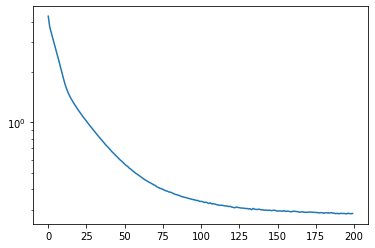

Accuracy by the propagration model is 0.9798


100%|██████████| 200/200 [00:02<00:00, 66.99it/s]


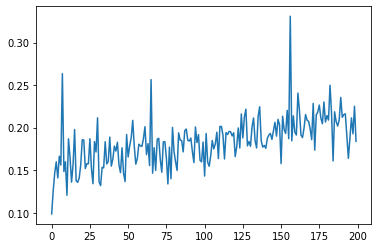

Task 0, Accuracy: 0.9796


100%|██████████| 200/200 [12:06<00:00,  3.63s/it]


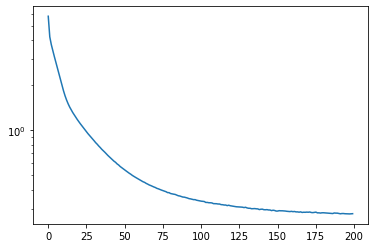

Accuracy by the propagration model is 0.7426


100%|██████████| 200/200 [00:06<00:00, 31.93it/s]


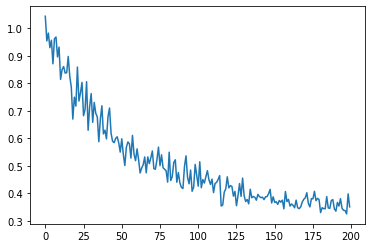

Task 1, Accuracy: 0.9738


100%|██████████| 200/200 [12:07<00:00,  3.64s/it]


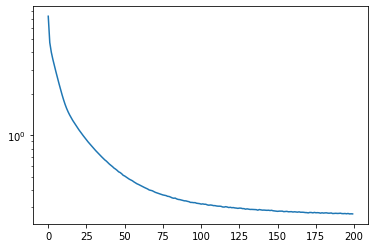

Accuracy by the propagration model is 0.8915


100%|██████████| 200/200 [00:09<00:00, 20.51it/s]


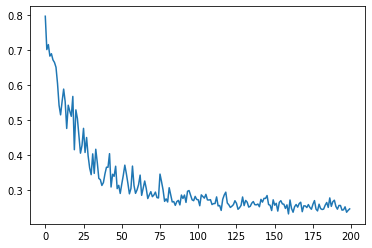

Task 2, Accuracy: 0.9754


100%|██████████| 200/200 [12:03<00:00,  3.62s/it]


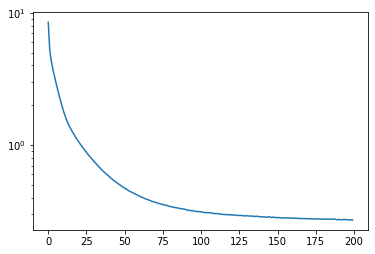

Accuracy by the propagration model is 0.9625


100%|██████████| 200/200 [00:12<00:00, 15.59it/s]


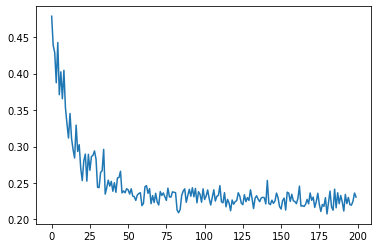

Task 3, Accuracy: 0.9741


100%|██████████| 200/200 [12:06<00:00,  3.63s/it]


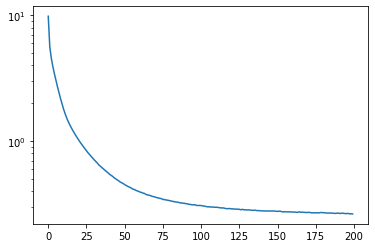

Accuracy by the propagration model is 0.9655


100%|██████████| 200/200 [00:13<00:00, 15.10it/s]


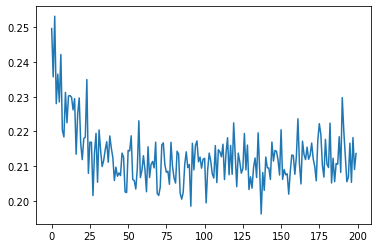

Task 4, Accuracy: 0.9714


100%|██████████| 200/200 [12:14<00:00,  3.67s/it]


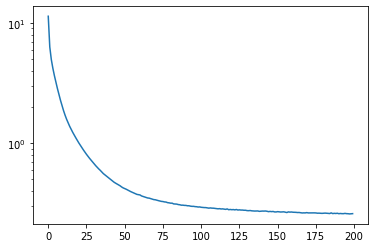

Accuracy by the propagration model is 0.9553


100%|██████████| 200/200 [00:16<00:00, 12.47it/s]


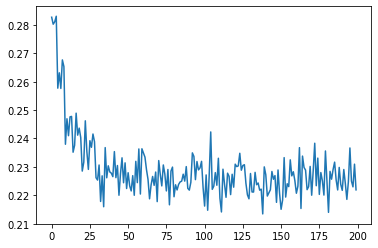

Task 5, Accuracy: 0.9673


100%|██████████| 200/200 [12:12<00:00,  3.66s/it]


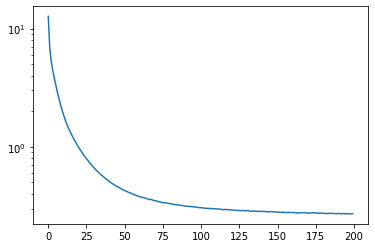

Accuracy by the propagration model is 0.9544


100%|██████████| 200/200 [00:19<00:00, 10.27it/s]


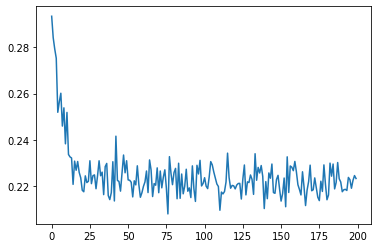

Task 6, Accuracy: 0.9658


100%|██████████| 200/200 [12:57<00:00,  3.89s/it]


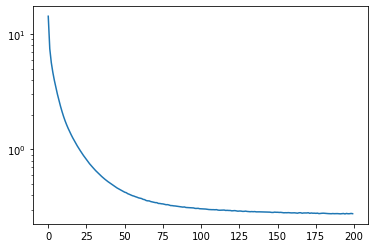

Accuracy by the propagration model is 0.9488


100%|██████████| 200/200 [00:23<00:00,  8.55it/s]


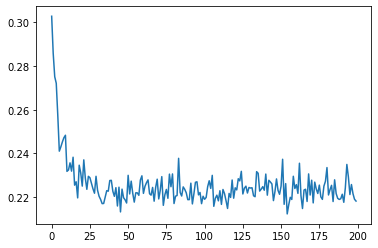

Task 7, Accuracy: 0.9630


100%|██████████| 200/200 [12:10<00:00,  3.65s/it]


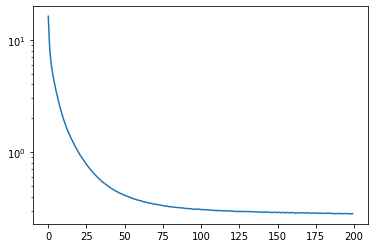

Accuracy by the propagration model is 0.9364


100%|██████████| 200/200 [00:26<00:00,  7.67it/s]


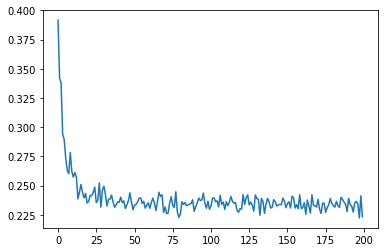

Task 8, Accuracy: 0.9583


100%|██████████| 200/200 [12:11<00:00,  3.66s/it]


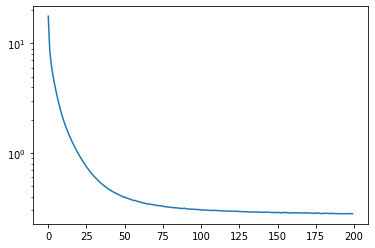

Accuracy by the propagration model is 0.9281


100%|██████████| 200/200 [00:27<00:00,  7.19it/s]


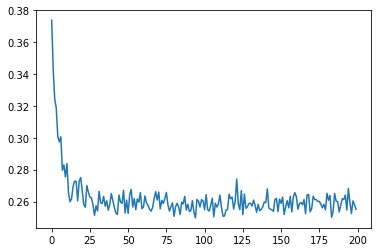

Task 9, Accuracy: 0.9550


In [ ]:
for task in range(10):
    train_x, train_y, test_x, test_y = get_pMNIST(task, device)
    Test_x.append(test_x)
    Test_y.append(test_y)
    
    # define current model
    current_model = VCL_permute_MNIST(previous_model=previous_model, random_initialize=True).to(device)
    current_opt = torch.optim.Adam(current_model.parameters(), lr=0.001)

    # get coreset
    if random_coreset:
        coreset_idx = np.random.choice(train_x.shape[0], coreset_size, False)
    else:
        coreset_idx = np.array(KCenter(coreset_size).fit_tranform(train_x.cpu().detach().numpy())) 
    train_idx = np.delete(np.arange(train_x.shape[0]), coreset_idx)
    new_coreset_x = train_x[coreset_idx]
    new_coreset_y = train_y[coreset_idx]
    train_x = train_x[train_idx]
    train_y = train_y[train_idx]

    if coreset_x == None:
        coreset_x = new_coreset_x
        coreset_y = new_coreset_y
    else:
        coreset_x = torch.cat([new_coreset_x, coreset_x])
        coreset_y = torch.cat([new_coreset_y, coreset_y])

    ELBO = []
    for epoch in tqdm(range(n_epoch)):
        ELBO_batch = []
        for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            
            current_opt.zero_grad()
            elbo = current_model.calculate_IWAE_Bound(x=train_x[batch_idx0: batch_idx1], 
                                                      y=train_y[batch_idx0: batch_idx1], 
                                                      n_particles=1,
                                                      dataset_size=train_x.shape[0],
                                                      k_IWAE=5)
            elbo.backward()
            nn.utils.clip_grad_value_(current_model.parameters(), 5)
            current_opt.step()
            ELBO_batch.append(elbo.item())
        ELBO.append(np.mean(ELBO_batch))
    plt.plot(ELBO)
    plt.yscale("log")
    plt.show()

    test_x_tensor = torch.cat(Test_x)
    test_y_tensor = torch.cat(Test_y)
    pred_y = []
    with torch.no_grad():
        for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_logit_samples = nn.Softmax(-1)(torch.stack(current_model.predict(test_x_tensor[batch_idx0: batch_idx1], 100), 0)).mean(0)
            pred_y.append(pred_logit_samples.argmax(-1))
        pred_y = torch.cat(pred_y)
        acc = (pred_y == test_y_tensor).cpu().numpy().mean()
    print("Accuracy by the propagration model is %.4f"%acc)
        
    # calculate prediction model
    pred_model = VCL_permute_MNIST(previous_model=current_model, random_initialize=False).to(device)
    pred_opt = torch.optim.Adam(pred_model.parameters(), lr=0.001)

    ELBO = []
    for epoch in tqdm(range(n_epoch)):
        ELBO_batch = []
        for batch in range(int(np.ceil(coreset_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_opt.zero_grad()
            elbo = pred_model.calculate_IWAE_Bound(x=coreset_x[batch_idx0: batch_idx1], 
                                                   y=coreset_y[batch_idx0: batch_idx1], 
                                                   n_particles=1,
                                                   dataset_size=coreset_x.shape[0],
                                                   k_IWAE=5)
            elbo.backward()
            nn.utils.clip_grad_value_(pred_model.parameters(), 5)
            pred_opt.step()
            ELBO_batch.append(elbo.item())
        ELBO.append(np.mean(ELBO_batch))
    plt.plot(ELBO)
    plt.show()
            
    test_x_tensor = torch.cat(Test_x)
    test_y_tensor = torch.cat(Test_y)
    pred_y = []
    with torch.no_grad():
        for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_logit_samples = nn.Softmax(-1)(torch.stack(pred_model.predict(test_x_tensor[batch_idx0: batch_idx1], 100), 0)).mean(0)
            pred_y.append(pred_logit_samples.argmax(-1))
        pred_y = torch.cat(pred_y)
        acc = (pred_y == test_y_tensor).cpu().numpy().mean()
    Accuracies.append(acc)
    print("Task {:d}, Accuracy: {:.4f}".format(task, acc))
    previous_model = current_model

In [ ]:
print(Accuracies)

[0.9796, 0.9738, 0.9753666666666667, 0.9741, 0.97144, 0.9673333333333334, 0.9657857142857142, 0.963025, 0.9583333333333334, 0.95503]


Text(0, 0.5, 'Accuracy')

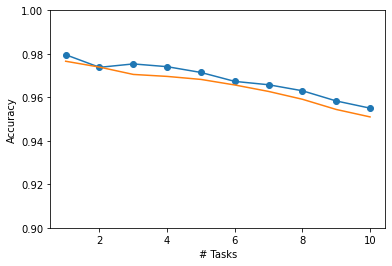

In [ ]:
plt.plot(np.arange(1, 11), Accuracies)
plt.scatter(np.arange(1, 11), Accuracies)
plt.plot(np.arange(1, 11), [0.9766, 0.9739, 0.9705333333333334, 0.969625, 0.96824, 0.9656833333333333, 0.9627142857142857, 0.9591125, 0.9544222222222222, 0.951])
plt.ylim(0.9, 1)
plt.xlabel("# Tasks")
plt.ylabel("Accuracy")

In [ ]:
# from google.colab import runtime
# runtime.unassign()